# Preliminaries

Import libraries, set a format for graphs, define some functions to draw graphs fast, once given the dataset.

Requisites: Python 3 + standard conda installation + [LMFIT](https://lmfit.github.io/lmfit-py/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import rc

import seaborn as sns
from scipy import stats
from datetime import date,timedelta
import locale
import lmfit

import importlib
from os import system

%matplotlib inline

Next cell is for Matplolib format

In [2]:
locale.setlocale(locale.LC_TIME,'es_ES.utf8')

def to_cm(width = 9, hratio = 1.0 / 1.618):
    to_inch = 2.54
    w = width / to_inch
    h = w * hratio
    return (w,h)

rc('font', **{'family':'serif'})
rc('text', usetex=True)

#Some global constants
GLW = 2.0      #Line width
GFS_LABEL = 14 #Axis Label
GFS_TICK = 12  #Axis tick
GFS_TITLE = 16 #Title size
GFS_CREDITS = 8 #Credits

#Auxvariable 
PREVIEW_DPI = 200 #Increase DPI to make plots appear larger in Jupyter

Now we set up the file paths that we intend to use to load and ouput data! Note: we create the directory of TODAY using UNIX commands. This is OS dependent!!

In [3]:
ANDALUCIA_CSV = "../data/datos_andalucia_ultimo.csv"
GRAPHS_OUT = "../graficas/" + str(date.today()) + "/"
system("mkdir " + GRAPHS_OUT[:-1]) #Exclude last character, the </>

0

Auxiliary functions that are useful: string to dates

In [4]:
def str_2_date(stringarray):
    if isinstance(stringarray, list):
        resultado = []
        for fecha in stringarray:
            splitdate = fecha.split("-")
            resultado.append(date(int(splitdate[0]), int(splitdate[1]), int(splitdate[2])))
        return resultado
    else:
        splitdate = stringarray.split("-")
        return date(int(splitdate[0]), int(splitdate[1]), int(splitdate[2]))

Next cell is the shortcut in order to produce beautiful graphs with just one line of code

In [5]:
def create_graph(dates, datapoints, ylabel, title, filepath,
                 source="Junta de Andalucia", moving_avg=0, 
                startdate="2020-02-25", enddate=str(date.today()), 
                legend_loc="best"):
    """
    Create a simple visualization of the selected data. 
    *dates: array with the selected dates
    *datapoints: values corresponding to these dates
    *ylabel: the label of the y-axis
    *title: graph title
    *filepath: where to save it
    *source: where the data came from
    *startdata and enddate: to show just a portion of the graph
    *legend_loc: maptlotlib legend location
    """
    
    pal = sns.color_palette("dark")

    
    #Get a moving average if specified
    if moving_avg > 1:
        mean_short = datapoints.rolling(window=moving_avg).mean()  

        
    plt.figure(figsize=to_cm(15))
    
    #Plot data + moving average
    plt.plot(dates, datapoints, ls="none", marker=".", label="Datos", color="grey")
    if moving_avg > 1:
        plt.plot(dates, mean_short, label="Promedio {0} días".format(moving_avg),
                 color=pal.pop(0), lw=GLW)

    #Legend
    plt.legend(loc=legend_loc, fontsize=GFS_TICK)

    #Set label and ticks 
    plt.xlabel("Fecha", fontsize=GFS_LABEL)
    plt.ylabel(ylabel, fontsize=GFS_LABEL)
    plt.xticks(rotation=45, fontsize=GFS_TICK)
    plt.yticks(fontsize=GFS_TICK)

    #Format the date
    date_form = DateFormatter("%d-%b")
    plt.gca().xaxis.set_major_formatter(date_form)
    
    #Set bounds
    plt.xlim(startdate, enddate)

    #Title and source
    plt.suptitle(title + " COVID-19 Granada", fontsize=GFS_TITLE)
    plt.title(r"\emph{Fuente: " + source + "}", fontsize=GFS_TICK)

    plt.text(0.075,0.1, r"Victor Buendia / @Victor\textunderscore Seven7", 
             fontsize=GFS_CREDITS, transform=plt.gcf().transFigure)
    plt.text(0.14,0.075, r"\emph{victorseven.github.io}", 
             fontsize=GFS_CREDITS, transform=plt.gcf().transFigure)

    #Save and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filepath + ".pdf", bbox_inches="tight")
    plt.savefig(filepath + ".png", bbox_inches="tight", dpi=400)
    plt.show()

Finally, auxiliary function + a make fit that takes the data, makes a fit using the lmfit package and produces a graph, all at once!

In [6]:
def mask_dates(date0_st, datef_st, fechas):
    """
    Auxiliary function needed for the fit. 
    Takes two date strings (initial and final) and the dates array
    and filters it to the correspondent selected dates
    Returns: masked data, selected dates array
    """
    date0, datef = str_2_date([date0_st, datef_st])
    mask = (fechas >= date0_st) & (fechas < datef_st)
    numdays = (datef - date0).days
        
    fechas_timespan = [date0 + timedelta(days=j) for j in range(numdays)]
        
    return mask, fechas_timespan


def make_fit(fechas, datos, models, observables, date_start_fit, 
            date_end_fit, date_start_show, date_end_show, date_end_pred, rate_par,
             filepath, sigma=2, ylim=None, logscale=False, text_pos=(0.175, 0.55),
            ylabel="Casos Activos", title="Casos Activos", 
             source="Junta de Andalucia", legend_loc="best"):
    """
    Makes a fit of the provided data, using the models indicated. Parameters to
    this function are:
    *fechas: array of dates, like dataframe.dates
    *datos: the quantity to be fitted, array-like
    *models: dictionary of models, in format {"name" : func}. name is the string 
    that will be used in the legend. func is a callable object. Make sure that its
    indepedent variable is called x, and that parameters have initial values, 
    because these will be used as initial guesses
    *observables: dictionary of functions (as before), but this time to retrieve
    observables, like duplication time or similar... its arguments will always be
    a dictionary of the parameters
    *date_start_fit, date_end_fit: interval of dates to fit
    *date_start_show, date_end_show: will show data until this date
    *date_end_pred: will show predictions of the model until this date
    *filepath: where to save the grahs
    *rate_par: string name of the parameter that encondes exponential growth, 
    or other parameter of interest to see its error. Can be null
    *sigma: confidence level, in sigmas. 2 (95%) by default
    *text_post: position of model fit 
    For the others, check the function for graphs
    """
    
    
    #Get the timespan where we'll do the fit and the prediction
    mask_fit, dates_fit = mask_dates(date_start_fit, date_end_fit, fechas)
    mask_pred, dates_pred = mask_dates(date_start_fit, date_end_pred, fechas)
    mask_show, dates_show = mask_dates(date_start_show, date_end_show, fechas)

    #Get time spans explicitly -they have to be provided as arguments
    ndays_fit, ndays_pred = np.size(dates_fit), np.size(dates_pred)
    fit_timespan = np.arange(ndays_fit)
    pred_timespan = np.arange(ndays_pred)

    #Start the figure and plot data
    plt.figure(figsize=to_cm(15))
    plt.plot(dates_show, datos[mask_show],  zorder=2,
             ls="none", marker=".", label="Datos", color="black")

    pal = sns.color_palette("dark") #Init palette

    
    #For each function, create a LMFIT model and fit it!!
    for func_key in models:
        
        model = lmfit.Model(models[func_key])
        
        #Create parameters by default, using the function definition itself
        #in order to get the initial guess
        model_pars = model.make_params() 
        model_fit = model.fit(datos[mask_fit].values, model_pars, x=fit_timespan)

        print(model_fit.fit_report())
        print("")
        
        #Get the observables and show them
        if observables != None:
            for j,quan_key in enumerate(observables):
                quantity = observables[quan_key](model_fit.params)
                text ="{key} $= {value:.2f}\pm{error:.1f}$".format(key=quan_key, value=quantity[0], error=quantity[1])
                
                plt.text(text_pos[0], text_pos[1]+j*0.05, text,
                        fontsize=GFS_TICK, transform=plt.gcf().transFigure)
        
        predictions = model_fit.eval(x=pred_timespan)
        model_error = model_fit.eval_uncertainty(model_fit.params, x=pred_timespan, 
                                                 sigma=sigma)
        
        #Plot fit AND confidence intervals for all the prediction
        basecolor = pal.pop(0)
        plt.plot(dates_pred, predictions, color=basecolor, 
                 label=func_key)

        plt.fill_between(dates_pred, 
                         predictions - model_error, 
                         predictions + model_error, 
                         color=basecolor, alpha=0.3)
        
        
        #Get a naive stimation on error in the growh rate
        rate = model_fit.params[rate_par]

        #Evaluate the model in each one of the deviated parameters
        rate.set(value = rate.value - rate.stderr*sigma)
        model_fit.params[rate_par].set(value=rate.value)
        error_lower = model_fit.eval(params=model_fit.params, x=pred_timespan)
        
        #(the same, but 2* to make value + error)
        rate.set(value = rate.value + 2*rate.stderr*sigma)
        model_fit.params[rate_par].set(value=rate.value)
        error_upper = model_fit.eval(params=model_fit.params, x=pred_timespan)
        
        #Fill it!
        plt.fill_between(dates_pred, error_lower, error_upper, 
                         color=basecolor, alpha=0.2)

    
    #Legend
    plt.legend(loc=legend_loc, fontsize=GFS_TICK)

    #Set label and ticks 
    plt.xlabel("Fecha", fontsize=GFS_LABEL)
    plt.ylabel(ylabel, fontsize=GFS_LABEL)
    plt.xticks(rotation=45, fontsize=GFS_TICK)
    plt.yticks(fontsize=GFS_TICK)

    #Format the date
    date_form = DateFormatter("%d-%b")
    plt.gca().xaxis.set_major_formatter(date_form)
    
    #Limits of the graphs and scale
    if ylim != None:
        if type(ylim) is list:
            plt.ylim(ylim[0], ylim[1])
        else:
            plt.ylim(0.85 * np.min(datos[mask_pred].values), ylim)
    
    if logscale:
        plt.yscale("log")
        
        
    #Title and source
    plt.suptitle(title + " COVID-19 Granada", fontsize=GFS_TITLE)
    plt.title(r"\emph{Fuente:" + source + "}", fontsize=GFS_TICK)

    #Credits
    plt.text(0.075,0.1, r"Victor Buendia / @Victor\textunderscore Seven7", 
             fontsize=GFS_CREDITS, transform=plt.gcf().transFigure)
    plt.text(0.14,0.075, r"\emph{victorseven.github.io}", 
             fontsize=GFS_CREDITS, transform=plt.gcf().transFigure)
    

    #Save and show
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filepath + ".pdf", bbox_inches="tight")
    plt.savefig(filepath + ".png", bbox_inches="tight", dpi=400)
    plt.show()
    plt.close()

# Filtro de datos de la Junta de Andalucia

El siguiente script es capaz de filtrar los datos de la Junta, obtenidos de [esta web](https://www.juntadeandalucia.es/institutodeestadisticaycartografia/badea/operaciones/consulta/anual/38228?CodOper=b3_6&codConsulta=38228), después de abrirlos con OpenOffice Calc/Excel y copiar/pegar la tabla de datos a un documento de texto plano (notepad, gedit). Ese documento se pasa por el script, generando un CSV mucho más amigable. El script está en un fichero Python aparte por facilidad de uso para terceros usuarios 

In [14]:
import filter_Junta_data

#Import and reload just in case of changes between calls
importlib.reload(filter_Junta_data)
from filter_Junta_data import create_provinces_csv

#Create the CSV filter by provinces
create_provinces_csv()

# Load data and visualize it

Let's load the CSV and then make the visualization of the complete series, for context, and for the selected province. Also produce some graphs for the last days.

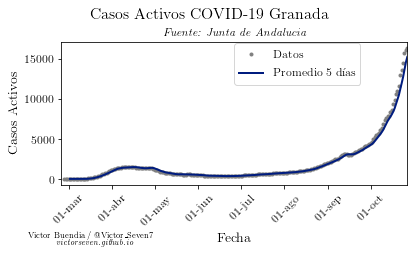

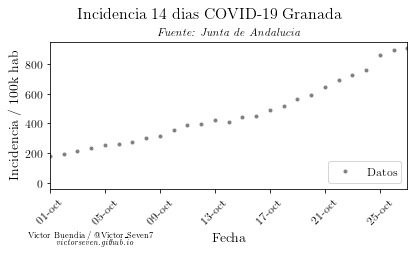

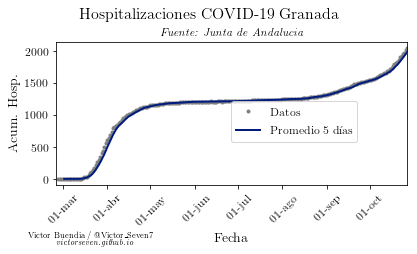

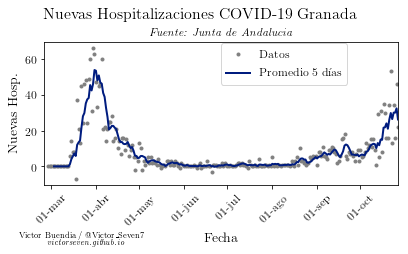

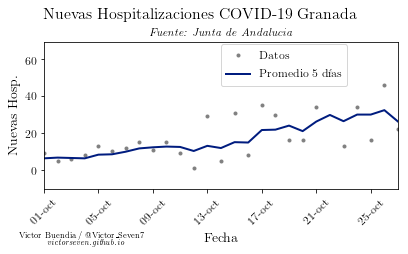

In [21]:
data = pd.read_csv(ANDALUCIA_CSV, parse_dates=[0])
data_pr = data[data["Territorio"] == "Granada"]

#Casos activos
activos = data_pr.Total_confirmados - data_pr.Curados

create_graph(data_pr.Fecha, activos, "Casos Activos", "Casos Activos", GRAPHS_OUT+"gr_active_total",
            moving_avg = 5, legend_loc=(0.5,0.7), enddate="2020-10-27")

#Incidencia a 14 dias
incidencia = 100000 * data_pr.Confirmados_PDIA_14_días / 912075.0
create_graph(data_pr.Fecha, incidencia, "Incidencia / 100k hab", "Incidencia 14 dias", GRAPHS_OUT+"gr_active_14",
            moving_avg = 0, legend_loc="lower right", startdate="2020-10-01", enddate="2020-10-27")

#Hospitalizaciones
create_graph(data_pr.Fecha, data_pr.Hospitalizados, "Acum. Hosp.", "Hospitalizaciones", GRAPHS_OUT+"gr_acum_hosp",
            moving_avg = 5, legend_loc=(0.5,0.3), enddate="2020-10-27")

nuevos_hospi = data_pr.Hospitalizados.diff()

create_graph(data_pr.Fecha, nuevos_hospi, "Nuevas Hosp.", "Nuevas Hospitalizaciones", GRAPHS_OUT+"gr_new_hosp_total",
            moving_avg = 5, legend_loc=(0.5,0.7), enddate="2020-10-27")

create_graph(data_pr.Fecha, nuevos_hospi, "Nuevas Hosp.", "Nuevas Hospitalizaciones", GRAPHS_OUT+"gr_new_hosp",
            moving_avg = 5, legend_loc=(0.5,0.7), startdate="2020-10-01", enddate="2020-10-27")

# Make fits 
In the next cell, we get the date of active cases and hospitalizations in the last days and FIT IT!

[[Model]]
    Model(pure_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 20
    # variables        = 2
    chi-square         = 10524.4904
    reduced chi-square = 584.693912
    Akaike info crit   = 129.314559
    Bayesian info crit = 131.306024
[[Variables]]
    n0:  742.413459 +/- 8.11247526 (1.09%) (init = 150)
    r:   0.04941302 +/- 8.0094e-04 (1.62%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(n0, r) = -0.923



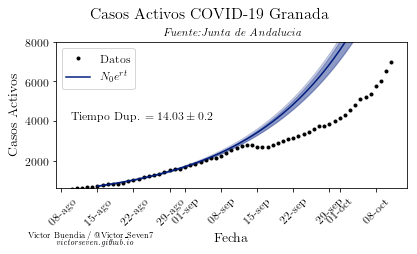

[[Model]]
    Model(pure_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 13
    # variables        = 2
    chi-square         = 20528.3538
    reduced chi-square = 1866.21399
    Akaike info crit   = 99.7399686
    Bayesian info crit = 100.869867
[[Variables]]
    n0:  2603.66320 +/- 20.8763975 (0.80%) (init = 150)
    r:   0.02902551 +/- 0.00103585 (3.57%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(n0, r) = -0.879



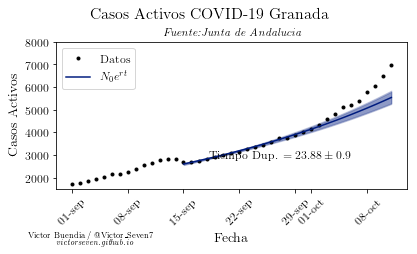

[[Model]]
    Model(pure_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 10
    # variables        = 2
    chi-square         = 31071.5867
    reduced chi-square = 3883.94834
    Akaike info crit   = 84.4146398
    Bayesian info crit = 85.0198100
[[Variables]]
    n0:  3981.04359 +/- 33.3349493 (0.84%) (init = 150)
    r:   0.04609249 +/- 0.00140599 (3.05%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(n0, r) = -0.882



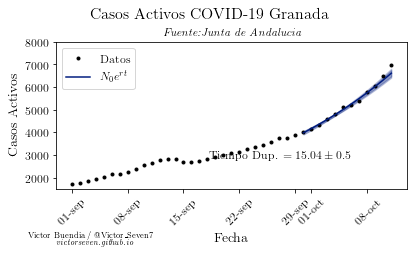

In [19]:
#Read and prepare data and observables
data = pd.read_csv(ANDALUCIA_CSV, parse_dates=[0])
data_pr = data[data["Territorio"] == "Granada"]
activos = data_pr.Total_confirmados - data_pr.Curados - data_pr.Fallecidos

#The function to be optized
def corr_exp(x, a=150.0, r=0.05, n0=500.0):
    return a*(np.exp(r*x)-1) + n0

#Duplication time for corr exp
def corr_dup_time(pars_dict):
    a,r,n0 = pars_dict["a"].value, pars_dict["r"].value, pars_dict["n0"].value
    da,dr,dn0 = pars_dict["a"].stderr, pars_dict["r"].stderr, pars_dict["n0"].stderr
    logaux = np.log((a+n0)/a)
    
    value = logaux/r
    
    error = (a*dn0 +n0*da)*r / (a*(a+n0)) + dr*logaux 
    error /= r**2
    
    return value, error

#The function to be optized
def pure_exp(x, n0=150.0, r=0.05):
    return n0*np.exp(r*x)

#Duplication time for pure exp
def pure_dup_time(pars_dict):
    r,dr = pars_dict["r"].value, pars_dict["r"].stderr
    
    value = np.log(2)/r
    error = value * dr / r
    
    return value, error


def saturation(pars_dict):
    a,r,n0 = pars_dict["a"].value, pars_dict["r"].value, pars_dict["n0"].value
    da,dr,dn0 = pars_dict["a"].stderr, pars_dict["r"].stderr, pars_dict["n0"].stderr
    
    value = n0**2 / (n0-a)
    error = n0 * (n0 * da + dn0 * np.abs(n0-2*a)) / (n0-a)**2
    
    return value,error

models_dict = {r"$N_0 e^{rt}$":pure_exp}
observ_dict = {"Tiempo Dup.": pure_dup_time}

#Friendly reminder:
#date arguments are
#fit, start and end;
#show in graph, start and end
#end of prediction
make_fit(data_pr.Fecha, activos, models_dict, observ_dict,
         "2020-08-15", "2020-09-04", 
         "2020-08-10", "2020-10-12",
         "2020-10-12",
         "r", GRAPHS_OUT + "gr_fit_agosto",  ylim=8000, logscale=False)


make_fit(data_pr.Fecha, activos, models_dict, observ_dict,
         "2020-09-15", "2020-09-28", 
         "2020-09-1", "2020-10-12",
         "2020-10-12", 
         "r", GRAPHS_OUT + "gr_fit_28_sept",  ylim=[1500,8000], logscale=False,
         text_pos = (0.5,0.4))


make_fit(data_pr.Fecha, activos, models_dict, observ_dict,
         "2020-09-30", "2020-10-10", 
         "2020-09-1", "2020-10-12",
         "2020-10-12", 
         "r", GRAPHS_OUT + "gr_fit_octubre",  ylim=[1500,8000], logscale=False,
         text_pos = (0.5,0.4))